In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)



In [2]:
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def evaluate_model(embeddings, labels, threshold=0.5):
    class_similarities = defaultdict(list)
    correct = 0
    total = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                class_similarities[labels[i]].append(sim)
                if sim > threshold:
                    correct += 1
            else:
                if sim <= threshold:
                    correct += 1
            total += 1

    accuracy = correct / total
    return accuracy, class_similarities

def load_images_from_folder(folder):
    images = []
    labels = []
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            images.append(img)
            labels.append(class_folder_name)
    return images, labels

### 1. 같은 label끼리의 유사도 측정

In [ ]:
def main():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()
    layer = 'default'
    
    # 예시 이미지 및 레이블 (사용자가 제공해야 함)
    images = [Image.open('./data-gatter/train/BOLD/377985.jpg'), Image.open('./data-gatter/train/BOLD/378152.jpg'), Image.open('./data-gatter/train/BOLD/378225.jpg')]
    labels = ['BOLD', 'BOLD', 'BOLD']
    
    # 평가 결과 저장
    results = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name, layer=layer)
        
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)
        
        accuracy, class_similarities = evaluate_model(embeddings, labels)
        
        results[model_name] = {
            'accuracy': accuracy,
            'class_similarities': class_similarities,
            'processing_time': processing_time
        }
        
        print(f"Model {model_name} - Accuracy: {accuracy}, Processing Time: {processing_time} per image")
    
    # 결과 출력 또는 저장
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Processing Time per Image: {result['processing_time']}")
        print(f"Class Similarities: {result['class_similarities']}")

if __name__ == "__main__":
    main()

### 2. 이미지 N개를 대상으로 각 이미지가 다른 N-1개의 이미지와 유사도를 계산하고, 이를 통해 잘 분류된 클래스와 잘못 분류된 클래스의 개수를 파악
- threshold 변경해도 차이 별로x. (0.5 -> 0.3, 0.1, 0.8, 0.9 : 동일)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def evaluate_model(embeddings, labels, threshold=0.5):
    class_similarities = defaultdict(list)
    correct = 0
    total = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                class_similarities[labels[i]].append(sim)
                if sim > threshold:
                    correct += 1
            else:
                if sim <= threshold:
                    correct += 1
            total += 1

    accuracy = correct / total
    return accuracy, class_similarities


def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # 허용된 이미지 파일 확장자 목록
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:  # 파일 확장자 확인
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


def main():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()
    layer = 'default'
    
    # 폴더에서 이미지와 레이블 불러오기
    folder_path = './data-gatter/train'
    images, labels = load_images_from_folder(folder_path)
    
    # 각 클래스당 최소 2개 이상의 이미지가 필요
    required_label_count = 2
    # 각 카테고리별 이미지 수 확인
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    # 카테고리별 이미지 수가 충분한지 확인
    if any(count < required_label_count for count in label_counts.values()):
        print("각 클래스에는 최소 2개의 이미지가 필요합니다.")
        return

    # 평가 결과 저장
    results = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name, layer=layer)
        
        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)
        
        # 평가 모델 사용하여 정확도 계산
        threshold = 0.5
        accuracy, class_similarities = evaluate_model(embeddings, labels, threshold)
        
        # 올바르게 분류된 데이터 수 및 분류되지 않은 데이터 수 계산
        correct_classifications = 0
        incorrect_classifications = 0

        for i, embedding in enumerate(embeddings):
            similarities = []
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    similarities.append((sim, labels[j]))
            
            # 유사도 기준으로 정렬
            similarities.sort(reverse=True, key=lambda x: x[0])
            
            # 가장 유사한 이미지와 해당 유사도 출력
            most_similar_label = similarities[0][1]
            
            # 분류 결과 확인
            if most_similar_label == labels[i]:
                correct_classifications += 1
            else:
                incorrect_classifications += 1
        
        # 정확도 수정_
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images
        
        results[model_name] = {
            'accuracy': accuracy,
            'class_similarities': class_similarities,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time
        }
        
        print(f"Model {model_name} - Correct Classifications: {correct_classifications}, Incorrect Classifications: {incorrect_classifications}, Processing Time: {processing_time} per image")
    
    # 결과 출력 또는 저장
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")
        print(f"Class Similarities: {result['class_similarities']}")

if __name__ == "__main__":
    main()


### 2. 결과
Model: resnet18
Correct Classifications: 31
Incorrect Classifications: 5
Processing Time per Image: 0.05470755365159777

Model: resnet50
Correct Classifications: 30
Incorrect Classifications: 6
Processing Time per Image: 0.1096413532892863

Model: efficientnet_b0
Correct Classifications: 16
Incorrect Classifications: 20
Processing Time per Image: 0.06240766578250461

Model: efficientnet_b3
Correct Classifications: 21
Incorrect Classifications: 15
Processing Time per Image: 0.10402288701799181
(venv) hahyeonji@hahyeonjiui-MacBookPro ImageImbedding % 

### 2. 에서 각 이미지의 임베딩 값도 같이 출력, (accuracy 때문에 대혼란) - 여기선 evaluate_model 함수의 accuracy이고 classification 결과는 main 에서의 분류결과를 나타낸것.

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 임베딩(벡터)와 레이블 사용해 모델의 정확도 평가 - 유사도 임계값을 기준으로 올바르게 분류된 쌍의 비율을 계산
def evaluate_model(embeddings, labels, threshold):
    class_similarities = defaultdict(list)
    correct = 0
    total = 0

    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
            if labels[i] == labels[j]:
                class_similarities[labels[i]].append(sim)
                if sim > threshold:
                    correct += 1
            else:
                if sim <= threshold:
                    correct += 1
            total += 1

    accuracy = correct / total
    return accuracy, class_similarities

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # 허용된 이미지 파일 확장자 목록
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:  # 파일 확장자 확인
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


def main():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()
    layer = 'default'
    
    # 폴더에서 이미지와 레이블 불러오기
    folder_path = './data-gatter/train'
    images, labels = load_images_from_folder(folder_path)
    
    # 각 클래스당 최소 2개 이상의 이미지가 필요
    required_label_count = 2
    # 각 카테고리별 이미지 수 확인
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    # 카테고리별 이미지 수가 충분한지 확인
    if any(count < required_label_count for count in label_counts.values()):
        print("각 클래스에는 최소 2개의 이미지가 필요합니다.")
        return

    # 평가 결과 저장
    results = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name, layer=layer)
        
        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)
        
        # 평가 모델 사용하여 정확도 계산
        threshold = 0.5
        accuracy, class_similarities = evaluate_model(embeddings, labels, threshold)
        
        # 잘 분류된 클래스와 잘못 분류된 클래스 계산
        correct_classifications = defaultdict(int)
        incorrect_classifications = defaultdict(int)

        total_correct = 0
        total_incorrect = 0

        for i, embedding in enumerate(embeddings):
            similarities = []
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    similarities.append((sim, labels[j]))
            
            # 유사도 기준으로 정렬
            similarities.sort(reverse=True, key=lambda x: x[0])
            
            # 가장 유사한 이미지의 레이블
            most_similar_label = similarities[0][1]
            
            # 분류 결과 확인
            if most_similar_label == labels[i]:
                correct_classifications[labels[i]] += 1
                total_correct += 1
            else:
                incorrect_classifications[labels[i]] += 1
                total_incorrect += 1
        
        results[model_name] = {
            'accuracy': accuracy,
            'class_similarities': class_similarities,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time,
            'total_correct': total_correct,
            'total_incorrect': total_incorrect
        }
        
        print(f"Model {model_name} - Processing Time: {processing_time} per image")
    
    # 결과 출력 또는 저장
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Total Correct Classifications: {result['total_correct']}")
        print(f"Total Incorrect Classifications: {result['total_incorrect']}")
        print(f"Processing Time per Image: {result['processing_time']}")
        print(f"Class Similarities: {result['class_similarities']}")
        print("Correct Classifications:")
        for label, count in result['correct_classifications'].items():
            print(f"  {label}: {count}")
        print("Incorrect Classifications:")
        for label, count in result['incorrect_classifications'].items():
            print(f"  {label}: {count}")

if __name__ == "__main__":
    main()


Model: resnet18
Accuracy: 0.14285714285714285
Total Correct Classifications: 31
Total Incorrect Classifications: 5
Processing Time per Image: 0.06275461117426555
Class Similarities: defaultdict(<class 'list'>, {'DUST': [0.6001026, 0.53807384, 0.9493884, 0.54201394, 0.82975245, 0.8602035, 0.61878675, 0.87639034, 0.65792805, 0.5657732, 0.9791348, 0.61132973, 0.5671531, 0.915514, 0.61289144], 'BURR': [0.7781271, 0.9284715, 0.76342845, 0.8108454, 0.7897095, 0.7741957, 0.80353606, 0.7535825, 0.81127834, 0.78037083, 0.8186377, 0.8189117, 0.81996256, 0.896101, 0.84166086], 'DOT': [0.8536985, 0.85882974, 0.8305161, 0.84968317, 0.8298479, 0.9281166, 0.88934636, 0.83101875, 0.85062665, 0.92213213, 0.8681096, 0.8182904, 0.8897617, 0.81204057, 0.8109412], 'BUBBLE': [0.7703301, 0.7713212, 0.6419724, 0.89030564, 0.79348904, 0.5757905, 0.7169981, 0.76072043, 0.96819353, 0.6010142, 0.7506037, 0.596917, 0.6340326, 0.7169784, 0.7654363], 'BOLD': [0.7789995, 0.88758177, 0.7582421, 0.85858905, 0.81812966, 0.73470795, 0.9518256, 0.695719, 0.9369452, 0.7190074, 0.8716805, 0.79979587, 0.6591646, 0.92920244, 0.72366077], 'DAMAGE': [0.66376376, 0.8035166, 0.8039102, 0.73163474, 0.78607035, 0.7310408, 0.7571741, 0.6395329, 0.67981064, 0.86540115, 0.73969877, 0.8165145, 0.71747375, 0.8027081, 0.70580083]})
Correct Classifications:
  DUST: 6
  BURR: 4
  DOT: 6
  BUBBLE: 5
  BOLD: 6
  DAMAGE: 4
Incorrect Classifications:
  BURR: 2
  BUBBLE: 1
  DAMAGE: 2

Model: resnet50
Accuracy: 0.14285714285714285
Total Correct Classifications: 30
Total Incorrect Classifications: 6
Processing Time per Image: 0.12785636054144967
Class Similarities: defaultdict(<class 'list'>, {'DUST': [0.61705756, 0.55926436, 0.9567903, 0.55929494, 0.92152, 0.9219435, 0.6773299, 0.90910363, 0.70902765, 0.6190162, 0.98842055, 0.6515464, 0.61400175, 0.95483375, 0.647736], 'BURR': [0.777568, 0.9020001, 0.8261082, 0.862092, 0.80820096, 0.80475134, 0.8562846, 0.7108218, 0.80849266, 0.868747, 0.85221004, 0.83971417, 0.8113427, 0.8728665, 0.80198], 'DOT': [0.86121213, 0.8421737, 0.7843202, 0.8679179, 0.8614478, 0.9034014, 0.8598916, 0.87437975, 0.8510826, 0.9050518, 0.8790137, 0.83261365, 0.8969681, 0.83286107, 0.8773044], 'BUBBLE': [0.7640948, 0.8246045, 0.6435535, 0.88657117, 0.78054756, 0.6276556, 0.76226246, 0.7135753, 0.9754814, 0.6203302, 0.8142369, 0.6227167, 0.6036109, 0.7319559, 0.71531487], 'BOLD': [0.77138364, 0.9042731, 0.7793336, 0.8334779, 0.8077489, 0.7983791, 0.9538292, 0.80720913, 0.91110194, 0.7957515, 0.8865381, 0.8069916, 0.8049986, 0.9154985, 0.8228679], 'DAMAGE': [0.7637502, 0.835957, 0.84270084, 0.79230416, 0.84850043, 0.7361436, 0.7541573, 0.6820943, 0.6954595, 0.8437828, 0.7864474, 0.7701396, 0.7554374, 0.84396756, 0.73614895]})
Correct Classifications:
  DUST: 6
  BURR: 4
  DOT: 5
  BUBBLE: 5
  BOLD: 6
  DAMAGE: 4
Incorrect Classifications:
  BURR: 2
  DOT: 1
  BUBBLE: 1
  DAMAGE: 2

Model: efficientnet_b0
Accuracy: 0.7507936507936508
Total Correct Classifications: 16
Total Incorrect Classifications: 20
Processing Time per Image: 0.06536852651172215
Class Similarities: defaultdict(<class 'list'>, {'DUST': [-0.13152933, -0.09557498, 0.7509824, -0.07606883, 0.6126944, 0.91317904, -0.15710256, 0.91592324, -0.18517235, -0.1080755, 0.9902494, -0.13842978, -0.09473304, 0.80374783, -0.12725697], 'BURR': [-0.082971714, 0.89776844, -0.14330362, -0.09794522, 0.53148186, -0.120223686, 0.6769149, 0.36531407, 0.009515939, -0.16067114, -0.111673675, 0.4623048, 0.62933224, 0.01577626, 0.0039786287], 'DOT': [0.025647188, 0.0123753995, 0.0012437142, 0.033796452, 0.052951697, 0.8054329, 0.67700106, 0.83804, 0.42725527, 0.89325184, 0.8351203, 0.31471747, 0.7667023, 0.20714186, 0.36583087], 'BUBBLE': [0.6926166, 0.2729605, 0.26380616, 0.22804569, 0.4842757, 0.2303946, 0.29071224, 0.20908237, 0.69211555, 0.58204913, 0.3759123, 0.16557488, 0.5065632, 0.23898357, 0.23616421], 'BOLD': [-0.11430626, 0.66154224, -0.04425245, 0.54309666, -0.104347184, -0.10720118, 0.906031, -0.13503286, 0.9655404, -0.049425516, 0.5853907, -0.099055395, -0.060948595, 0.8883899, -0.12364669], 'DAMAGE': [-0.1534439, 0.19700375, 0.059871707, 0.35977662, 0.0523519, 0.016384955, 0.2167495, -0.01772985, 0.31034195, 0.1930649, 0.16777751, 0.3233468, 0.0778311, 0.4676621, 0.12329185]})
Correct Classifications:
  DUST: 5
  BURR: 1
  DOT: 1
  BUBBLE: 5
  BOLD: 2
  DAMAGE: 2
Incorrect Classifications:
  DUST: 1
  BURR: 5
  DOT: 5
  BUBBLE: 1
  BOLD: 4
  DAMAGE: 4

Model: efficientnet_b7
Accuracy: 0.2857142857142857
Total Correct Classifications: 23
Total Incorrect Classifications: 13
Processing Time per Image: 0.2156504193941752
Class Similarities: defaultdict(<class 'list'>, {'DUST': [0.34381083, 0.21505383, 0.98427415, 0.43858957, 0.85019755, 0.6931971, 0.2874999, 0.7203119, 0.48054194, 0.15253966, 0.94625175, 0.42242616, 0.39250416, 0.82188916, 0.5656338], 'BURR': [0.7793501, 0.85145676, 0.7125516, 0.7582659, 0.9003099, 0.72041523, 0.84242105, 0.78972703, 0.81107163, 0.65737516, 0.6189538, 0.90561193, 0.65487945, 0.7729525, 0.70785105], 'DOT': [0.8393124, 0.8868328, 0.89319074, 0.8743707, 0.7206726, 0.9278182, 0.8718964, 0.8715538, 0.82095957, 0.90687144, 0.90973717, 0.77878416, 0.9297477, 0.82158494, 0.81408644], 'BUBBLE': [0.87683886, 0.46940288, 0.82717264, 0.75214934, 0.8502173, 0.13090758, 0.93697786, 0.4519376, 0.9821197, 0.15053894, 0.8278872, 0.12729174, 0.42500865, 0.9308605, 0.4492649], 'BOLD': [0.55928755, 0.763012, 0.495019, 0.81053996, 0.503875, 0.48287305, 0.9641124, 0.64014244, 0.9356107, 0.44301492, 0.7821515, 0.43561652, 0.61919355, 0.9355072, 0.6175692], 'DAMAGE': [0.3107702, 0.7847667, 0.7821056, 0.5105388, 0.81290734, 0.4639718, 0.19325778, 0.6477406, 0.31198722, 0.85771215, 0.63285905, 0.81702805, 0.2930688, 0.8692167, 0.4246933]})
Correct Classifications:
  DUST: 4
  BURR: 1
  DOT: 6
  BUBBLE: 5
  BOLD: 5
  DAMAGE: 2
Incorrect Classifications:
  DUST: 2
  BURR: 5
  BUBBLE: 1
  BOLD: 1
  DAMAGE: 4
(venv) hahyeonji@hahyeonjiui-MacBookPro ImageImbedding % 






=============================================================================================================================




=============================================================================================================================

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def evaluate_model(embeddings, labels, threshold):
    correct_classifications = 0
    incorrect_classifications = 0

    for i, embedding in enumerate(embeddings):
        similarities = []
        for j in range(len(embeddings)):
            if i != j:
                sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                similarities.append((sim, labels[j]))

        # 유사도 기준으로 정렬
        similarities.sort(reverse=True, key=lambda x: x[0])

        # 분류 결과 확인
        if similarities[0][0] > threshold and similarities[0][1] == labels[i]:
            correct_classifications += 1
        else:
            incorrect_classifications += 1

    return correct_classifications, incorrect_classifications

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # 허용된 이미지 파일 확장자 목록
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:  # 파일 확장자 확인
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def main():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()
    layer = 'default'
    
    # 폴더에서 이미지와 레이블 불러오기
    folder_path = './data-gatter/train'
    images, labels = load_images_from_folder(folder_path)
    
    # 각 클래스당 최소 2개 이상의 이미지가 필요
    required_label_count = 2
    # 각 카테고리별 이미지 수 확인
    label_counts = {label: labels.count(label) for label in set(labels)}
    
    # 카테고리별 이미지 수가 충분한지 확인
    if any(count < required_label_count for count in label_counts.values()):
        print("각 클래스에는 최소 2개의 이미지가 필요합니다.")
        return

    # 평가 결과 저장
    results = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name, layer=layer)
        
        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)
        
        # 다양한 임계값에 대해 평가
        best_threshold = 0
        best_correct = 0
        best_incorrect = len(images)
        thresholds = np.arange(0.1, 1.0, 0.05)

        for threshold in thresholds:
            correct, incorrect = evaluate_model(embeddings, labels, threshold)
            if correct > best_correct and incorrect < best_incorrect:
                best_threshold = threshold
                best_correct = correct
                best_incorrect = incorrect

        results[model_name] = {
            'best_threshold': best_threshold,
            'correct_classifications': best_correct,
            'incorrect_classifications': best_incorrect,
            'processing_time': processing_time
        }
        
        print(f"Model {model_name} - Best Threshold: {best_threshold}, Correct Classifications: {best_correct}, Incorrect Classifications: {best_incorrect}, Processing Time: {processing_time} per image")
    
    # 결과 출력 또는 저장
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Best Threshold: {result['best_threshold']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")

if __name__ == "__main__":
    main()


## 1. Nearest Neighbor 기반 평가
### - 각 이미지에 대해 다른 모든 이미지와의 코사인 유사도 계산
### - 유사도가 가장 높은 이미지 선택
### - 선택한 이미지의 레이블이 현재 이미지의 레이블과 일치하는지 확인해 정확도 계산
### - 새로운 이미지가 주어졌을 때 해당 이미지가 어떤 클래스로 분류될지를 시뮬레이션 하는 방식

Model: resnet18
Accuracy: 0.8611111111111112
Correct Classifications: 31
Incorrect Classifications: 5
Processing Time per Image: 0.059573855664994985

Model: resnet50
Accuracy: 0.8333333333333334
Correct Classifications: 30
Incorrect Classifications: 6
Processing Time per Image: 0.1250338355700175

Model: efficientnet_b0
Accuracy: 0.4444444444444444
Correct Classifications: 16
Incorrect Classifications: 20
Processing Time per Image: 0.06705013910929362

Model: efficientnet_b7
Accuracy: 0.6388888888888888
Correct Classifications: 23
Incorrect Classifications: 13
Processing Time per Image: 0.3125931951734755

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


def classify_images(model_names, folder_path, cuda=False):
    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        # 올바르게 분류된 데이터 수 및 분류되지 않은 데이터 수 계산
        correct_classifications = 0
        incorrect_classifications = 0

        for i, embedding in enumerate(embeddings):
            similarities = []
            for j in range(len(images)):
                if i != j:
                    sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                    similarities.append((sim, labels[j]))

            # 유사도 기준으로 정렬
            similarities.sort(reverse=True, key=lambda x: x[0])

            # 가장 유사한 이미지와 해당 유사도 출력
            most_similar_label = similarities[0][1]

            # 분류 결과 확인
            if most_similar_label == labels[i]:
                correct_classifications += 1
            else:
                incorrect_classifications += 1

        # 정확도 계산
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images

        results[model_name] = {
            'accuracy': accuracy,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")

## 1. 새로운 이미지 데이터가 들어왔을 때, 유사도가 높은 상위 10개의 레퍼런스 이미지 중 가장 많이 존재하는 레이블로 할당하여 분류

Model: resnet18
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
Predictions: ['DOT', 'DOT', 'BURR', 'BUBBLE', 'BOLD', 'DOT']

Model: resnet50
Accuracy: 0.5
Correct Classifications: 3
Incorrect Classifications: 3
Predictions: ['DUST', 'DOT', 'BURR', 'BUBBLE', 'BOLD', 'DOT']

Model: efficientnet_b0
Accuracy: 0.0
Correct Classifications: 0
Incorrect Classifications: 6
Predictions: ['DAMAGE', 'BOLD', 'BOLD', 'DUST', 'BURR', 'BURR']

Model: efficientnet_b7
Accuracy: 0.5
Correct Classifications: 3
Incorrect Classifications: 3
Predictions: ['DUST', 'DOT', 'DOT', 'BUBBLE', 'BURR', 'DOT']

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import Counter
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


def classify_images(model_names, reference_folder, new_folder, cuda=False):
    # 레퍼런스 이미지와 레이블 불러오기
    ref_images, ref_labels = load_images_from_folder(reference_folder)
    
    # 새로운 이미지와 레이블 불러오기
    new_images, new_labels = load_images_from_folder(new_folder)

    results = {}
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 레퍼런스 임베딩 추출
        ref_embeddings = [img2vec.get_vec(img) for img in ref_images]
        ref_embeddings = np.array(ref_embeddings)

        correct_classifications = 0
        incorrect_classifications = 0
        predictions = []

        for i, new_image in enumerate(new_images):
            new_embedding = img2vec.get_vec(new_image)
            similarities = []

            for j in range(len(ref_images)):
                sim = cosine_similarity([new_embedding], [ref_embeddings[j]])[0][0]
                similarities.append((sim, ref_labels[j]))

            # 유사도 기준으로 정렬 후 상위 10개 선택
            similarities.sort(reverse=True, key=lambda x: x[0])
            top_10_similarities = similarities[:10]

            # 가장 많이 등장하는 레이블 선택
            top_10_labels = [label for _, label in top_10_similarities]
            predicted_label = Counter(top_10_labels).most_common(1)[0][0]
            predictions.append((predicted_label, new_labels[i]))

            # 분류 결과 확인
            if predicted_label == new_labels[i]:
                correct_classifications += 1
            else:
                incorrect_classifications += 1

        # 정확도 계산
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images

        results[model_name] = {
            'accuracy': accuracy,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'predictions': predictions
        }

    return results

if __name__ == "__main__":
    reference_folder = './data-gatter/train'
    new_folder = './data-gatter/test'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, reference_folder, new_folder, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Predictions:")
        for pred, true_label in result['predictions']:
            print(f"Predicted: {pred}, Actual: {true_label}")

## 2. Threshold 기반 평가 
### - 모든 이미지 간의 코사인 유사도 계산
### - 동일한 레이블 가진 이미지 쌍의 유사도가 주어진 임계값보다 높은지, 다른 레이블을 사진 이미지 쌍의 유사도가 임계값 이하인지를 기준으로 정확도 평가

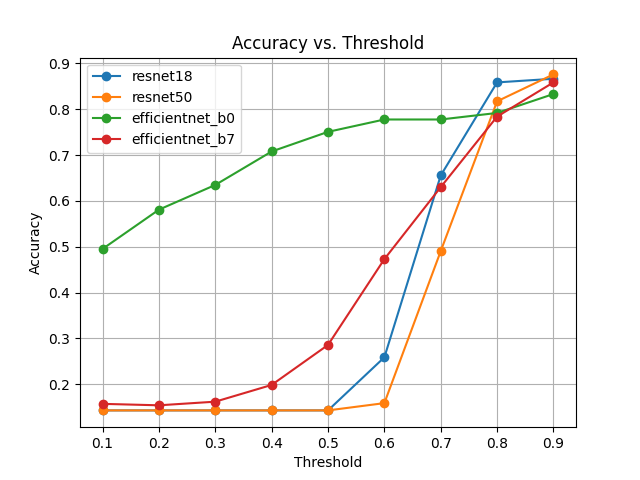

Evaluating model resnet18
Model: resnet18, Threshold: 0.1, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.2, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.30000000000000004, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.4, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.5, Accuracy: 0.14285714285714285
Model: resnet18, Threshold: 0.6, Accuracy: 0.25873015873015875
Model: resnet18, Threshold: 0.7000000000000001, Accuracy: 0.6555555555555556
Model: resnet18, Threshold: 0.8, Accuracy: 0.8587301587301587
Model: resnet18, Threshold: 0.9, Accuracy: 0.8666666666666667

Evaluating model resnet50
Model: resnet50, Threshold: 0.1, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.2, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.30000000000000004, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.4, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.5, Accuracy: 0.14285714285714285
Model: resnet50, Threshold: 0.6, Accuracy: 0.15873015873015872
Model: resnet50, Threshold: 0.7000000000000001, Accuracy: 0.49047619047619045
Model: resnet50, Threshold: 0.8, Accuracy: 0.8174603174603174
Model: resnet50, Threshold: 0.9, Accuracy: 0.8761904761904762

Evaluating model efficientnet_b0
Model: efficientnet_b0, Threshold: 0.1, Accuracy: 0.49523809523809526
Model: efficientnet_b0, Threshold: 0.2, Accuracy: 0.580952380952381
Model: efficientnet_b0, Threshold: 0.30000000000000004, Accuracy: 0.6349206349206349
Model: efficientnet_b0, Threshold: 0.4, Accuracy: 0.707936507936508
Model: efficientnet_b0, Threshold: 0.5, Accuracy: 0.7507936507936508
Model: efficientnet_b0, Threshold: 0.6, Accuracy: 0.7777777777777778
Model: efficientnet_b0, Threshold: 0.7000000000000001, Accuracy: 0.7777777777777778
Model: efficientnet_b0, Threshold: 0.8, Accuracy: 0.792063492063492
Model: efficientnet_b0, Threshold: 0.9, Accuracy: 0.8333333333333334

Evaluating model efficientnet_b7
Model: efficientnet_b7, Threshold: 0.1, Accuracy: 0.15714285714285714
Model: efficientnet_b7, Threshold: 0.2, Accuracy: 0.15396825396825398
Model: efficientnet_b7, Threshold: 0.30000000000000004, Accuracy: 0.1619047619047619
Model: efficientnet_b7, Threshold: 0.4, Accuracy: 0.1984126984126984
Model: efficientnet_b7, Threshold: 0.5, Accuracy: 0.2857142857142857
Model: efficientnet_b7, Threshold: 0.6, Accuracy: 0.473015873015873
Model: efficientnet_b7, Threshold: 0.7000000000000001, Accuracy: 0.6301587301587301
Model: efficientnet_b7, Threshold: 0.8, Accuracy: 0.7841269841269841
Model: efficientnet_b7, Threshold: 0.9, Accuracy: 0.8587301587301587

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 임베딩(벡터)와 레이블 사용해 모델의 정확도 평가 - 유사도 임계값을 기준으로 올바르게 분류된 쌍의 비율을 계산

def evaluate_model(embeddings, labels, thresholds):
    results = []

    for threshold in thresholds:
        class_similarities = defaultdict(list)
        correct = 0
        total = 0

        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                if labels[i] == labels[j]:
                    class_similarities[labels[i]].append(sim)
                    if sim > threshold:
                        correct += 1
                else:
                    if sim <= threshold:
                        correct += 1
                total += 1

        accuracy = correct / total
        results.append((threshold, accuracy))
    return results

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']  # 허용된 이미지 파일 확장자 목록
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:  # 파일 확장자 확인
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels


def plot_results(results, model_name):
    thresholds = [r[0] for r in results]
    accuracies = [r[1] for r in results]

    plt.plot(thresholds, accuracies, marker='o', label=model_name)

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.grid(True)

def main_evaluation():
    # 설정
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    folder_path = './data-gatter/train'
    cuda = torch.cuda.is_available()
    thresholds = np.arange(0.1, 1.0, 0.1)  # 다양한 임계값 설정

    # 이미지와 레이블 불러오기
    images, labels = load_images_from_folder(folder_path)

    results_all_models = {}
    
    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        # 모델 초기화
        img2vec = Img2Vec(cuda=cuda, model=model_name)

        # 임베딩 추출
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)

        # 성능 평가
        results = evaluate_model(embeddings, labels, thresholds)
        results_all_models[model_name] = results
        
        # 결과 출력
        for threshold, accuracy in results:
            print(f"Model: {model_name}, Threshold: {threshold}, Accuracy: {accuracy}")
        
        # 결과 그래프로 표시
        plot_results(results, model_name)
    
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main_evaluation()

## 2. 새 이미지와 기존 레퍼런스 이미지 간의 유사도 계산
- Threshold가 낮을수록 더 많은 이미지를 높은 유사도로 분류하지만, 잘못된 분류도 함께 증가할 수 있습니다.
- 주어진 예시에서, 낮은 threshold (0.1)에서 많은 이미지들이 잘못된 레이블로 분류되었습니다.
- Threshold 값을 높이면 유사도가 높은 경우에만 분류되기 때문에, 잘못된 분류가 줄어들 수 있지만, 너무 높으면 "Unknown"으로 분류되는 경우가 많아질 수 있습니다.

Model: resnet18
Threshold: 0.1
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.2
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.30000000000000004
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.4
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.5
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.6
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.7000000000000001
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: DOT, Similarity: 0.8687189817428589
New Image 3: Actual Label: DOT, Predicted Label: BURR, Similarity: 0.8907590508460999
New Image 4: Actual Label: BUBBLE, Predicted Label: BUBBLE, Similarity: 0.8769079446792603
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: DOT, Similarity: 0.8365391492843628

Model: resnet18
Threshold: 0.8
Accuracy: 0.3333333333333333
Correct Classifications: 2
Incorrect Classifications: 4
New Image 1: Actual Label: DUST, Predicted Label: BUBBLE, Similarity: 0.9488675594329834
New Image 2: Actual Label: BURR, Predicted Label: Unknown, Similarity: N/A
New Image 3: Actual Label: DOT, Predicted Label: Unknown, Similarity: N/A
New Image 4: Actual Label: BUBBLE, Predicted Label: Unknown, Similarity: N/A
New Image 5: Actual Label: BOLD, Predicted Label: BOLD, Similarity: 0.9077326059341431
New Image 6: Actual Label: DAMAGE, Predicted Label: Unknown, Similarity: N/A

Model: resnet18
Threshold: 0.9
Accuracy: 0.16666666666666666
Correct Classifications: 1
Incorrect Classifications: 5
(venv) hahyeonji@hahyeonjiui-MacBookPro ImageImbedding % 






In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

# 주어진 임베딩(벡터)간의 코사인 유사도 계산 - 두 벡터가 얼마나 유사한지 측정
def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

# 주어진 임베딩(벡터)와 레이블 사용해 모델의 정확도 평가 - 유사도 임계값을 기준으로 올바르게 분류된 쌍의 비율을 계산
def evaluate_model(embeddings, labels, thresholds):
    results = []

    for threshold in thresholds:
        class_similarities = defaultdict(list)
        correct = 0
        total = 0

        for i in range(len(embeddings)):
            for j in range(i + 1, len(embeddings)):
                sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
                if labels[i] == labels[j]:
                    class_similarities[labels[i]].append(sim)
                    if sim > threshold:
                        correct += 1
                else:
                    if sim <= threshold:
                        correct += 1
                total += 1

        accuracy = correct / total
        results.append((threshold, accuracy))
    return results

# 주어진 폴더에서 이미지 읽어오고, 이미지와 해당 레이블(폴더 이름) 반환
def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def plot_results(results, model_name):
    thresholds = [r[0] for r in results]
    accuracies = [r[1] for r in results]

    plt.plot(thresholds, accuracies, marker='o', label=model_name)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.grid(True)

def classify_new_images(model_name, reference_folder, new_images_folder, thresholds, cuda=False):
    # 기존 이미지와 레이블 불러오기
    reference_images, reference_labels = load_images_from_folder(reference_folder)
    
    # 새로운 이미지와 레이블 불러오기
    new_images, new_labels = load_images_from_folder(new_images_folder)
    
    # 모델 초기화
    img2vec = Img2Vec(cuda=cuda, model=model_name)
    
    # 임베딩 추출
    reference_embeddings = [img2vec.get_vec(img) for img in reference_images]
    reference_embeddings = np.array(reference_embeddings)
    
    new_embeddings = [img2vec.get_vec(img) for img in new_images]
    new_embeddings = np.array(new_embeddings)
    
    for threshold in thresholds:
        correct_classifications = 0
        incorrect_classifications = 0
        
        for i, new_embedding in enumerate(new_embeddings):
            similarities = []
            for j, ref_embedding in enumerate(reference_embeddings):
                sim = cosine_similarity([new_embedding], [ref_embedding])[0][0]
                if sim > threshold:
                    similarities.append((sim, reference_labels[j]))

            if similarities:
                # 유사도 기준으로 정렬
                similarities.sort(reverse=True, key=lambda x: x[0])
                most_similar_label = similarities[0][1]
            else:
                most_similar_label = "Unknown"
            
            # 분류 결과 확인
            if most_similar_label == new_labels[i]:
                correct_classifications += 1
            else:
                incorrect_classifications += 1

            print(f"New Image {i+1}: Actual Label: {new_labels[i]}, Predicted Label: {most_similar_label}, Similarity: {similarities[0][0] if similarities else 'N/A'}")
        
        # 정확도 계산
        total_images = correct_classifications + incorrect_classifications
        accuracy = correct_classifications / total_images if total_images > 0 else 0
        
        print(f"\nModel: {model_name}")
        print(f"Threshold: {threshold}")
        print(f"Accuracy: {accuracy}")
        print(f"Correct Classifications: {correct_classifications}")
        print(f"Incorrect Classifications: {incorrect_classifications}")

if __name__ == "__main__":
    reference_folder = './data-gatter/train'
    new_images_folder = './data-gatter/test'  # 새로운 이미지 폴더 경로
    model_name = 'resnet18'
    cuda = torch.cuda.is_available()
    thresholds = np.arange(0.1, 1.0, 0.1)  # 다양한 임계값 설정

    classify_new_images(model_name, reference_folder, new_images_folder, thresholds, cuda)

# 3. similarity threshold


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time
from collections import Counter
import certifi
import os
import ssl

# SSL 인증서 설정
os.environ['SSL_CERT_FILE'] = certifi.where()
ssl._create_default_https_context = ssl._create_unverified_context

# 이미지를 벡터로 변환(임베딩)하는 역할 (이미지 ->> 벡터)
class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='resnet18', layer='default', layer_output_size=512, gpu=0):
        self.device = torch.device(f"cuda:{gpu}" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    # 이미지를 입력으로 받아 벡터로 변환
    def get_vec(self, img, tensor=False):
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    # 주어진 모델 이름에 따라 모델과 해당 레이어 가져옴
    def _get_model_and_layer(self, model_name, layer):
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

def calculate_similarity(embeddings):
    return cosine_similarity(embeddings)

def load_images_from_folder(folder):
    images = []
    labels = []
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for class_folder_name in os.listdir(folder):
        class_folder_path = os.path.join(folder, class_folder_name)
        if not os.path.isdir(class_folder_path):
            continue
        for filename in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, filename)
            if os.path.splitext(filename)[1].lower() in valid_image_extensions:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(class_folder_name)
    return images, labels

def classify_images(model_names, folder_path, cuda=False):
    images, labels = load_images_from_folder(folder_path)
    results = {}

    for model_name in model_names:
        print(f"Evaluating model {model_name}")
        img2vec = Img2Vec(cuda=cuda, model=model_name)
        start_time = time.time()
        embeddings = [img2vec.get_vec(img) for img in images]
        embeddings = np.array(embeddings)
        processing_time = (time.time() - start_time) / len(images)

        correct_classifications = 0
        incorrect_classifications = 0

        thresholds = np.linspace(0, 1, 101)  # 0부터 1까지 101개의 임계값

        best_threshold = 0
        best_accuracy = 0

        for threshold in thresholds:
            correct_classifications = 0
            incorrect_classifications = 0

            for i, embedding in enumerate(embeddings):
                similarities = []
                for j in range(len(images)):
                    if i != j:
                        sim = cosine_similarity([embedding], [embeddings[j]])[0][0]
                        if sim >= threshold:
                            similarities.append((sim, labels[j]))

                if similarities:
                    similarities.sort(reverse=True, key=lambda x: x[0])
                    most_similar_label = similarities[0][1]

                    if most_similar_label == labels[i]:
                        correct_classifications += 1
                    else:
                        incorrect_classifications += 1

            total_images = correct_classifications + incorrect_classifications
            accuracy = correct_classifications / total_images

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold

        results[model_name] = {
            'best_threshold': best_threshold,
            'accuracy': best_accuracy,
            'correct_classifications': correct_classifications,
            'incorrect_classifications': incorrect_classifications,
            'processing_time': processing_time
        }

    return results

if __name__ == "__main__":
    folder_path = './data-gatter/train'
    model_names = ['resnet18', 'resnet50', 'efficientnet_b0', 'efficientnet_b7']
    cuda = torch.cuda.is_available()

    results = classify_images(model_names, folder_path, cuda)
    for model_name, result in results.items():
        print(f"\nModel: {model_name}")
        print(f"Best Threshold: {result['best_threshold']}")
        print(f"Accuracy: {result['accuracy']}")
        print(f"Correct Classifications: {result['correct_classifications']}")
        print(f"Incorrect Classifications: {result['incorrect_classifications']}")
        print(f"Processing Time per Image: {result['processing_time']}")